In [1]:
import numpy as np
import pandas as pd
from os import path as osp
import os
from matplotlib import pyplot as plt
import lightgbm as lgb

from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, fbeta_score, mean_absolute_percentage_error
import utils

import pickle
def save_obj(obj, name):
    with open(name + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open(name + '.pickle', 'rb') as f:
        return pickle.load(f)

In [2]:
import warnings

# 禁用FutureWarning警告
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
DATA_PATH = '/data'
MODEL_PAHT = '/work/model'
SEED = 2222
if not os.path.exists(MODEL_PAHT):
    os.mkdir(MODEL_PAHT)
    
data_type='train'

In [4]:
def q1(x):
    return x.quantile(0.1)
def q2(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.7)
def q4(x):
    return x.quantile(0.9)
def mode_max(x):
    return x.mode().max()
def mode_min(x):
    return x.mode().min()
def mode_mean(x):
    return x.mode().mean()
def mode_std(x):
    return x.mode().std()
def mode_len(x):
    return x.mode().shape[0]
def mode_times(x):
    return x.value_counts().iloc[0]

In [5]:
def get_data(data_type='train'):
    train_base = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_base.csv'))
    train_base = train_base.sort_values(['cust_wid']).reset_index(drop=True)
    train_view = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_view.csv'), encoding='gbk')
    train_trx = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_trx.csv'))

    # deal base gdr_cd
    train_base['gdr_cd'] = train_base['gdr_cd'].map({'M':1, 'F':2})
    train_base['gdr_cd'] = train_base['gdr_cd'].fillna(0)

    # deal base cty_cd
    train_base['cty_cd'] = train_base['cty_cd'].str.slice(stop=2)
    train_base.cty_cd = train_base.cty_cd.fillna('NAN')
    cty_map = ['C', '44', '11', 'A', '31', '32', '37', '21', '42', '61', 'B', '33', '50', '12', '35', '36', '51', '43', '62', '53', '34', '23', '65', '41', 'NAN']
    cty_map = dict(zip(cty_map, range(1,len(cty_map)+1)))
    train_base['cty_cd'] = train_base['cty_cd'].map(cty_map).fillna(0)

    # idx = train_view.acs_tm.str.contains('下午')
    train_view.acs_tm = train_view.acs_tm.str.rstrip(':').str.replace('上午|下午', '', regex=True).str.replace('1492', '2022')
    train_view.acs_tm = pd.to_datetime(train_view.acs_tm)
    train_view['day'] = train_view.acs_tm.dt.day

    train_trx.trx_tm = train_trx.trx_tm.str.replace('1492', '2022')
    train_trx.trx_tm = pd.to_datetime(train_trx.trx_tm)
    train_trx['day'] = train_trx.trx_tm.dt.day

    train_view['day_diff'] = train_view['day'].max() - train_view['day']
    train_trx['day_diff'] = train_trx['day'].max() - train_trx['day']

    if data_type=='train':
        train_view['day'] -= 4
        train_trx['day'] -= 4
    elif data_type=='testa':
        train_view['day'] -= 3
        train_trx['day'] -= 3
    elif data_type=='testb':
        train_view['day'] -= 4
        train_trx['day'] -= 4

    print(train_trx['day'].max(), train_trx['day'].min())

    train_view['ntimes'] = train_view['day']//14
    train_trx['ntimes'] = train_trx['day']//14
    train_view['day'] %= 14
    train_trx['day'] %= 14

#     train_idx = pd.Index(train_base['cust_wid'], name='cust_wid')
#     tmp_idx = train_view['acs_tm'].isna()
#     train_view_nan = pd.DataFrame({'cust_wid': train_view[tmp_idx]['cust_wid'].unique(), 'view_nan': 1}).set_index('cust_wid').reindex(train_idx).fillna(0).reset_index(drop=True)

#     tmp_idx = train_trx['trx_tm'].isna()
#     train_trx_nan = pd.DataFrame({'cust_wid': train_trx[tmp_idx]['cust_wid'].unique(), 'trx_nan': 1}).set_index('cust_wid').reindex(train_idx).fillna(0).reset_index(drop=True)

#     train_base = pd.concat([train_base, train_view_nan, train_trx_nan], axis=1)



    train_view = train_view.query('day>=0').reset_index(drop=True)
    train_trx = train_trx.query('day>=0').reset_index(drop=True)


    train_view['day'] = train_view['day'].astype('int')
    train_trx['day'] = train_trx['day'].astype('int')

    train_view = train_view.sort_values(['cust_wid','acs_tm']).reset_index(drop=True)
    train_trx = train_trx.sort_values(['cust_wid','trx_tm']).reset_index(drop=True)

    page_id_enc = load_obj(osp.join(MODEL_PAHT, 'page_id_enc'))
    trx_id_enc = load_obj(osp.join(MODEL_PAHT, 'trx_id_enc'))

    train_view['page_enc'] = train_view['page_id'].map(page_id_enc)
    train_view['page_enc'] = train_view['page_enc'].fillna(page_id_enc['NAN'])
    train_trx['trx_enc'] = train_trx['trx_cd'].map(trx_id_enc)

    train_view['acs_tm_diff'] = train_view.groupby('cust_wid')['acs_tm'].diff().dt.total_seconds()
    train_trx['trx_tm_diff'] = train_trx.groupby('cust_wid')['trx_tm'].diff().dt.total_seconds()
    train_view['daytime'] = train_view['acs_tm'].dt.time.apply(lambda x: x.hour*3600 + x.minute*60 + x.second)
    train_trx['daytime'] = train_trx['trx_tm'].dt.time.apply(lambda x: x.hour*3600 + x.minute*60 + x.second)
    train_trx['flag'] = (train_trx['trx_amt'] >0).astype('int')

    train_idx = pd.Index(train_base['cust_wid'], name='cust_wid')

    view_agg_func = {
        'day':['mean', 'min', 'max', 'std', np.ptp, 'nunique'],
        'page_id':['count', 'nunique'], 
        'acs_tm_diff':['mean', 'min', 'max', 'std', 'median', 'sum'], 
        'daytime':['mean', 'min', 'max', 'std', np.ptp],
        'page_enc': [
            'mean', 'min', 'max', 'std', 'median', 'sum', 
            np.ptp, "sem", "mad", "skew", pd.Series.kurtosis, 
            q1, q2, q3, q4, 'last',
            # mode_max, mode_min, mode_mean, mode_std, mode_len, mode_times
        ],
        'day_diff': ['min'],
    }
    train_view_c = train_view.groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    train_view_c.columns = [f'vie_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_c.columns]
    train_base = pd.concat([train_base, train_view_c], axis=1)

    #     train_view_cn1 = train_view.query('ntimes==1').groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_view_cn1.columns = [f'vie_d_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_cn1.columns]

    #     train_view_cn0 = train_view.query('ntimes==0').groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_view_cn0.columns = [f'vie_d_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_cn0.columns]

    #     train_view_c = train_view_cn1-train_view_cn0
    #     train_base = pd.concat([train_base, train_view_c], axis=1)

    trx_agg_func = {
        'day':['mean', 'min', 'max', 'std', np.ptp, 'nunique'],
        'trx_cd':['count', 'nunique'], 
        'trx_tm_diff':['mean', 'min', 'max', 'std', 'median', 'sum'], 
        'daytime':['mean', 'min', 'max', 'std', np.ptp], 
        'trx_amt':['mean', 'min', 'max', 'std', 'median', 'sum', np.ptp, 'last'],
        'trx_enc': ['mean', 'min', 'max', 'std', 'median', 'sum', np.ptp, 'last'],
        'day_diff': ['min'],
    }
    train_trx_c = train_trx.groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    train_trx_c.columns = [f'trx_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    train_base = pd.concat([train_base, train_trx_c], axis=1)

    #     train_trx_c = train_trx.query('flag==1').groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_trx_c.columns = [f'trx_1_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    #     train_base = pd.concat([train_base, train_trx_c], axis=1)

    #     train_trx_c = train_trx.query('flag==0').groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_trx_c.columns = [f'trx_0_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    #     train_base = pd.concat([train_base, train_trx_c], axis=1)

    train_view['group'] = (train_view['acs_tm_diff']>5*60).cumsum()
    train_view['group'] -= train_view['cust_wid'].map(train_view.groupby('cust_wid').agg({'group':'min'}).to_dict()['group'])
    train_reg_base = pd.DataFrame()

    train_view_group = train_view.groupby(['cust_wid', 'group']).agg({'page_enc': ['mean', 'min', 'max', 'std'], 'page_id':['count', 'nunique'], 'daytime':['mean',]}).reset_index()
    train_view_group.columns = [f'{item[0]}_{item[1]}' if item[0] not in ['cust_wid', 'group'] else item[0] for item in train_view_group.columns]
    train_view_group = train_view_group.groupby(['cust_wid']).agg({
        'group': ['max'],
        'page_enc_mean': ['mean', 'min', 'max', 'std'],
        'page_enc_min': ['mean', 'min', 'max', 'std'],
        'page_enc_max': ['mean', 'min', 'max', 'std'],
        'page_enc_std': ['mean', 'min', 'max', 'std'],
        'page_id_count': ['mean', 'min', 'max', 'std'],
        'page_id_nunique': ['mean', 'min', 'max', 'std'],
        'daytime_mean': ['mean', 'min', 'max', 'std'],
    }).reindex(train_idx).reset_index(drop=True)
    train_view_group.columns = [f'vie_gop_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_group.columns]
    train_reg_base = pd.concat([train_reg_base,train_view_group], axis=1)
    
    
    train_idx = pd.MultiIndex.from_product([train_base['cust_wid'], range(14)], names=['cust_wid', 'day'])
    train_view_cust = train_view.groupby(['cust_wid', 'day'])['page_id'].agg(['count', 'nunique']).reset_index()
    train_trx_cust = train_trx.groupby(['cust_wid', 'day'])[['trx_cd', 'trx_amt']].agg({'trx_cd':['count', 'nunique'], 'trx_amt':['min', 'max', 'mean', 'std']}).reset_index()
    train_trx_cust.columns = [f'{item[0]}_{item[1]}' if item[0] in ['trx_cd', 'trx_amt'] else item[0] for item in train_trx_cust.columns]

    train_view_cust = train_view_cust.set_index(['cust_wid','day']).reindex(train_idx).reset_index().sort_values(['cust_wid','day']).reset_index(drop=True)
    train_trx_cust = train_trx_cust.set_index(['cust_wid','day']).reindex(train_idx).reset_index().sort_values(['cust_wid','day']).reset_index(drop=True)

    train_view_cust = train_view_cust[[item for item in train_view_cust.columns if item not in ['cust_wid','day']]]
    train_view_cust_cols = train_view_cust.columns
    train_view_cust = train_view_cust.values.reshape(train_base['cust_wid'].shape[0], 14*len(train_view_cust_cols))
    train_view_cust = pd.DataFrame(train_view_cust, columns=[f"view_cust_{item}_{day}" for day in range(14) for item in train_view_cust_cols])

    train_trx_cust = train_trx_cust[[item for item in train_trx_cust.columns if item not in ['cust_wid','day']]]
    train_trx_cust_cols = train_trx_cust.columns
    train_trx_cust = train_trx_cust.values.reshape(train_base['cust_wid'].shape[0], 14*len(train_trx_cust_cols))
    train_trx_cust = pd.DataFrame(train_trx_cust, columns=[f"trx_cust_{item}_{day}" for day in range(14) for item in train_trx_cust_cols])
    train_reg_base = pd.concat([train_reg_base, train_view_cust, train_trx_cust], axis=1)

    return train_base, train_reg_base

In [8]:
train_base, train_reg_base = get_data(data_type='train')
# testA_base, testA_reg_base = get_data(data_type='testa')
testB_base, testB_reg_base = get_data(data_type='testb')

27.0 -3.0
27.0 -3.0


In [9]:
train_weight = load_obj('model/prob')['prob']

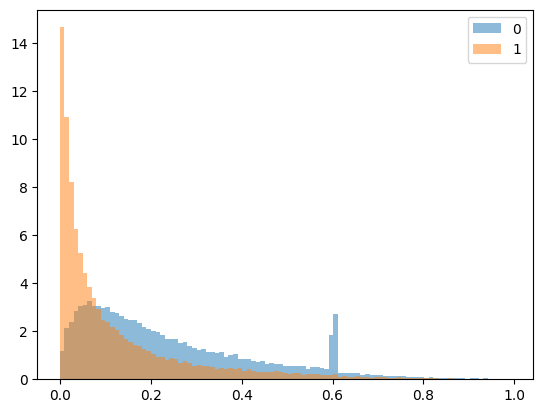

In [10]:
idx = train_base['label']==0
bins = np.linspace(train_weight.min(), train_weight.max(), 100)
plt.hist(train_weight[idx], bins=bins, density=True, alpha=0.5, label='0')
plt.hist(train_weight[~idx], bins=bins, density=True, alpha=0.5, label='1')
plt.legend()

In [11]:
not_use_cols = [
    'trx_trx_tm_diff_sum', 'trx_daytime_min', 'trx_trx_tm_diff_max', 'trx_trx_tm_diff_std','trx_day_diff_min', 
    'vie_day_std', 'vie_day_mean', 'vie_day_diff_min', 'trx_daytime_ptp',
    'vie_acs_tm_diff_sum', 'trx_trx_tm_diff_mean', 'trx_day_std'
]
train_base = train_base.drop(columns=not_use_cols)
testB_base = testB_base.drop(columns=not_use_cols)


In [12]:
FEATS = [item for item in train_base.columns if item not in ['cust_wid', 'label']]
TARGET_COL = 'label'
print(len(FEATS))

63


In [13]:
print(FEATS)

['age', 'gdr_cd', 'cty_cd', 'vie_day_min', 'vie_day_max', 'vie_day_ptp', 'vie_day_nunique', 'vie_page_id_count', 'vie_page_id_nunique', 'vie_acs_tm_diff_mean', 'vie_acs_tm_diff_min', 'vie_acs_tm_diff_max', 'vie_acs_tm_diff_std', 'vie_acs_tm_diff_median', 'vie_daytime_mean', 'vie_daytime_min', 'vie_daytime_max', 'vie_daytime_std', 'vie_daytime_ptp', 'vie_page_enc_mean', 'vie_page_enc_min', 'vie_page_enc_max', 'vie_page_enc_std', 'vie_page_enc_median', 'vie_page_enc_sum', 'vie_page_enc_ptp', 'vie_page_enc_sem', 'vie_page_enc_mad', 'vie_page_enc_skew', 'vie_page_enc_kurt', 'vie_page_enc_q1', 'vie_page_enc_q2', 'vie_page_enc_q3', 'vie_page_enc_q4', 'vie_page_enc_last', 'trx_day_mean', 'trx_day_min', 'trx_day_max', 'trx_day_ptp', 'trx_day_nunique', 'trx_trx_cd_count', 'trx_trx_cd_nunique', 'trx_trx_tm_diff_min', 'trx_trx_tm_diff_median', 'trx_daytime_mean', 'trx_daytime_max', 'trx_daytime_std', 'trx_trx_amt_mean', 'trx_trx_amt_min', 'trx_trx_amt_max', 'trx_trx_amt_std', 'trx_trx_amt_median'

In [16]:
class cv_model():
    def __init__(self, task_name='lgb', nfold=5, seed=SEED, save_path=MODEL_PAHT):
        self.nfold = nfold
        self.seed = seed
        self.save_path = save_path
        self.models = []
        self.task_name = task_name
    
    def save_model(self):
        for i, model in enumerate(self.models):
            save_obj(model, os.path.join(self.save_path, f"{self.task_name}_fold_{i}"))
    
    def load_model(self):
        self.models = []
        for i in range(self.nfold):
            model = load_obj(os.path.join(self.save_path, f"{self.task_name}_fold_{i}"))
            self.models.append(model)
    
    def fit(self, params, train_x, train_y, cat_feats, train_weight=None):
        kf = StratifiedKFold(n_splits=self.nfold, random_state=self.seed, shuffle=True)
        feat_imp = pd.DataFrame({'feat': train_x.columns})
        train_oof = np.zeros(len(train_x))
        for fold, (trn_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
            trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y.iloc[trn_idx], categorical_feature=cat_feats, weight=train_weight.iloc[trn_idx])
            val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y.iloc[val_idx], categorical_feature=cat_feats, weight=train_weight.iloc[val_idx])
            model = lgb.train(
                params,
                trn_data,
                num_boost_round=30000,
                valid_sets=[trn_data, val_data],
                categorical_feature=cat_feats,
                callbacks=[
                    lgb.early_stopping(100),
                    lgb.log_evaluation(100)
                ]
            )
            train_oof[val_idx] = model.predict(train_x.iloc[val_idx], num_iteration=model.best_iteration)
            self.models.append(model)
            feat_imp[f'fold_{fold}'] = feat_imp['feat'].map(dict(zip(model.feature_name(), model.feature_importance())))
        return train_oof, feat_imp
    def predict(self, test_x):
        test_pred = np.zeros(len(test_x))
        for i, model in enumerate(self.models):
            test_pred+=model.predict(test_x, num_iteration=model.best_iteration)/len(self.models)
        return test_pred
                                                         
            
            


In [63]:
cla_params = {
    'objective': 'binary', # multiclass multiclassova
    'metric': 'average_precision', #  average_precision auc map
    'boosting_type': 'gbdt',
    'num_leaves': 16,
    'min_data_in_leaf': 50,
    'lambda_l1':1,
    'lambda_l2':1,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_fraction_seed':SEED,
    'bagging_seed':SEED,
    'seed': SEED,
}
FEATS = [item for item in train_base.columns if item not in ['cust_wid', 'label']]
train_cla_x = train_base[FEATS]
train_cla_y = (train_base[TARGET_COL]>0).astype('int')
testB_cla_x = testB_base[FEATS]
print(train_cla_x.shape, train_cla_y.shape, testB_cla_x.shape)

cla_model = cv_model(task_name='cla_lgb', nfold=10)
train_cla_oof, feat_cla_imp = cla_model.fit(cla_params, train_cla_x, train_cla_y, cat_feats=['gdr_cd','cty_cd'], train_weight=train_weight)
cla_model.save_model()
cla_model.load_model()
test_cla_pred = cla_model.predict(testB_cla_x)


(100000, 63) (100000,) (50000, 63)


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.798456	valid_1's average_precision: 0.786187
[200]	training's average_precision: 0.813641	valid_1's average_precision: 0.787528
[300]	training's average_precision: 0.826192	valid_1's average_precision: 0.787736
[400]	training's average_precision: 0.837119	valid_1's average_precision: 0.787097
Early stopping, best iteration is:
[305]	training's average_precision: 0.826765	valid_1's average_precision: 0.787986


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.798526	valid_1's average_precision: 0.789615
[200]	training's average_precision: 0.813826	valid_1's average_precision: 0.789787
Early stopping, best iteration is:
[130]	training's average_precision: 0.803699	valid_1's average_precision: 0.790386


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.797841	valid_1's average_precision: 0.782783
[200]	training's average_precision: 0.813414	valid_1's average_precision: 0.786395
[300]	training's average_precision: 0.825809	valid_1's average_precision: 0.787922
[400]	training's average_precision: 0.836534	valid_1's average_precision: 0.788284
Early stopping, best iteration is:
[385]	training's average_precision: 0.834946	valid_1's average_precision: 0.788595


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.799382	valid_1's average_precision: 0.778766
[200]	training's average_precision: 0.814497	valid_1's average_precision: 0.780464
[300]	training's average_precision: 0.826541	valid_1's average_precision: 0.781564
[400]	training's average_precision: 0.837153	valid_1's average_precision: 0.781333
Early stopping, best iteration is:
[350]	training's average_precision: 0.831933	valid_1's average_precision: 0.7818


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.800437	valid_1's average_precision: 0.761772
[200]	training's average_precision: 0.815663	valid_1's average_precision: 0.764696
[300]	training's average_precision: 0.827591	valid_1's average_precision: 0.76575
[400]	training's average_precision: 0.838501	valid_1's average_precision: 0.76666
[500]	training's average_precision: 0.848071	valid_1's average_precision: 0.766326
Early stopping, best iteration is:
[436]	training's average_precision: 0.842167	valid_1's average_precision: 0.766823


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.798626	valid_1's average_precision: 0.780996
[200]	training's average_precision: 0.814121	valid_1's average_precision: 0.785704
[300]	training's average_precision: 0.826079	valid_1's average_precision: 0.786471
[400]	training's average_precision: 0.836912	valid_1's average_precision: 0.786022
Early stopping, best iteration is:
[311]	training's average_precision: 0.827256	valid_1's average_precision: 0.786757


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.797533	valid_1's average_precision: 0.794171
[200]	training's average_precision: 0.812888	valid_1's average_precision: 0.796328
[300]	training's average_precision: 0.825232	valid_1's average_precision: 0.797193
[400]	training's average_precision: 0.835949	valid_1's average_precision: 0.797419
Early stopping, best iteration is:
[318]	training's average_precision: 0.827308	valid_1's average_precision: 0.797775


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.798264	valid_1's average_precision: 0.783408
[200]	training's average_precision: 0.813898	valid_1's average_precision: 0.78666
[300]	training's average_precision: 0.825953	valid_1's average_precision: 0.787187
[400]	training's average_precision: 0.836739	valid_1's average_precision: 0.78764
[500]	training's average_precision: 0.84623	valid_1's average_precision: 0.787275
Early stopping, best iteration is:
[419]	training's average_precision: 0.838724	valid_1's average_precision: 0.787803


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.797607	valid_1's average_precision: 0.78796
[200]	training's average_precision: 0.813079	valid_1's average_precision: 0.789232
Early stopping, best iteration is:
[199]	training's average_precision: 0.812933	valid_1's average_precision: 0.78932


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.797858	valid_1's average_precision: 0.793048
[200]	training's average_precision: 0.813169	valid_1's average_precision: 0.794141
Early stopping, best iteration is:
[191]	training's average_precision: 0.811917	valid_1's average_precision: 0.794257


In [65]:
thr_optimal, best_fscore = utils.get_optimal_Fscore(train_cla_y, train_cla_oof, train_weight)
thr_optimal, best_fscore, (train_cla_oof>thr_optimal).sum() / train_cla_oof.shape[0]

以精度为0.1在[0.1,0.8]范围内搜索F1最佳阈值>>最佳阈值:=0.2->F1=0.751822
以精度为0.02在[0.1,0.28]范围内搜索F1最佳阈值>>最佳阈值:=0.14->F1=0.76027961
以精度为0.004在[0.09,0.18600000000000008]范围内搜索F1最佳阈值>>最佳阈值:=0.14200000000000004->F1=0.76005433


(0.14200000000000004, 0.76005433, 0.60726)

In [66]:
thr_optimal = thr_optimal*0.8

In [67]:
fbeta_score(train_cla_y, train_cla_oof>thr_optimal, beta=2, sample_weight=train_weight)

0.7557569980398681

In [68]:
thr_optimal

0.11360000000000003

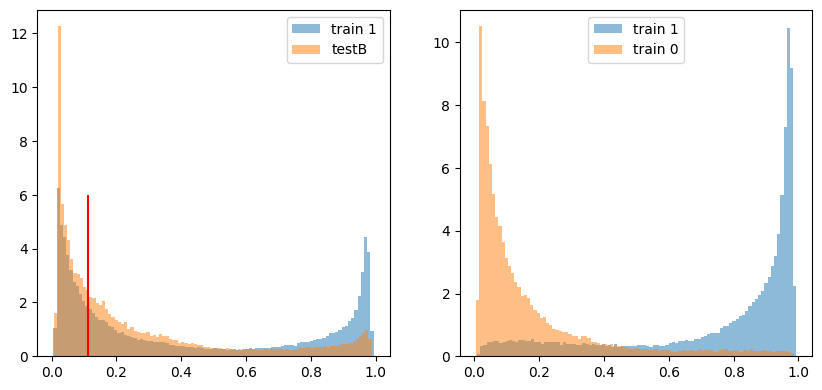

In [69]:
plt.figure(figsize=(10,4.5))
plt.subplot(121)
plt.hist(train_cla_oof, bins=100, alpha=0.5, label='train 1', density=True)
plt.hist(test_cla_pred, bins=100, alpha=0.5, label='testB', density=True)
plt.vlines(thr_optimal, 0, 6, color='r')
plt.legend()

plt.subplot(122)
idx = train_cla_y==1
plt.hist(train_cla_oof[idx], bins=100, alpha=0.5, label='train 1', density=True)
plt.hist(train_cla_oof[~idx], bins=100, alpha=0.5, label='train 0', density=True)
plt.legend()

In [70]:
feat_cla_imp['mean'] = feat_cla_imp[[f"fold_{fold}" for fold in range(cla_model.nfold)]].mean(axis=1)
feat_cla_imp = feat_cla_imp.sort_values(by="mean", ascending=False)
feat_cla_imp.to_csv('model/feats_cla_imp.csv', index=False)

In [71]:
corr_data = all_corr_data(train_cla_x,train_cla_y)
corr_data.to_csv('model/corr_cla.csv')

/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [72]:
test_cla_pred = (test_cla_pred>=thr_optimal).astype('int')
train_cla_oof = (train_cla_oof>=thr_optimal).astype('int')

In [78]:
test_pred = pd.DataFrame({'cust_wid': testB_base['cust_wid'], 'label': test_cla_pred})
train_oof = pd.DataFrame({'cust_wid': train_base['cust_wid'], 'pred': train_cla_oof, 'true': train_base['label']})

idx = test_pred.label == 1
test_pred.loc[idx, 'label'] = 3

# idx = train_oof.pred == 1
# train_oof.loc[idx, 'pred'] = train_reg_oof

In [79]:
score1 = fbeta_score((train_oof['true']>0).astype('int'), (train_oof['pred']>0).astype('int'), beta=2, sample_weight=train_weight)
# score2 = mean_absolute_percentage_error(train_reg_y, train_reg_oof)
score2 = 1
score = score1-0.2*score2
score, score1, score2


(0.555756998039868, 0.7557569980398681, 1)

In [80]:
test_pred.label.value_counts()

3    27599
0    22401
Name: label, dtype: int64

In [81]:
test_pred.to_csv('output.csv', index=False)